# Deep Learning Project
## Training an LSTM Network to Predict Li-Ion Battery Performance Over Time
### Project Jupyter Notebook
Name: Andrea Hwang\
Presentation Date: June 3, 2025\
Class: AISV.X401 at UCSC Silicon Valley Extension
#### Dataset
NASA Battery Dataset from Kaggle (https://www.kaggle.com/datasets/patrickfleith/nasa-battery-dataset/data)
#### Referenced Code
Contains parts from TensorFlow Time Series Forecasting Tutorial: https://www.tensorflow.org/tutorials/structured_data/time_series

### Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import IPython

### Battery Data
Read from csv files processed in clean-data.ipynb

In [2]:
class BatteryData:
    def __init__(self, id):
        self.id = id
        self.df = None

    def read_data(self):
        csv_file = f"{self.id}_charge_discharge.csv"
        dataframe = pd.read_csv(csv_file)
        dataframe = dataframe.drop(['Unnamed: 0'],axis=1)
        dataframe['Time'] = dataframe['Time']/3600
        self.df = dataframe
    
    def plot_full_data(self):
        plt.figure(figsize=(100, 10))
        plt.plot(self.df['Time'], self.df['Voltage_measured'])
        plt.xticks(fontsize=48)
        plt.yticks(fontsize=48)
        plt.xlabel('Time (hours)', fontsize=48)
        plt.ylabel('Voltage Measured (V)', fontsize=48)
        plt.title(f'Voltage Measured vs. Time for Battery {self.id}', fontsize=48)
        plt.savefig(f'{self.id}_voltage_time_full.png')

    def plot_voltage_current_temperature(self, start_time, end_time):
        plot_cols = ['Time', 'Voltage_measured', 'Current_measured', 'Temperature_measured']
        plot_features = self.df[plot_cols][start_time:end_time]
        _ = plot_features.plot(x='Time', subplots=True)

    def prepare_dataset(self, train_frac, test_frac):
        scaler = MinMaxScaler()
        df = pd.DataFrame(scaler.fit_transform(self.df), columns=self.df.columns)
        n = len(self.df)
        print(n)
        train_df = df[0:int(n*train_frac)]
        val_df = df[int(n*train_frac):int(n*(1-test_frac))]
        test_df = df[int(n*(1-test_frac)):]
        return train_df, val_df, test_df


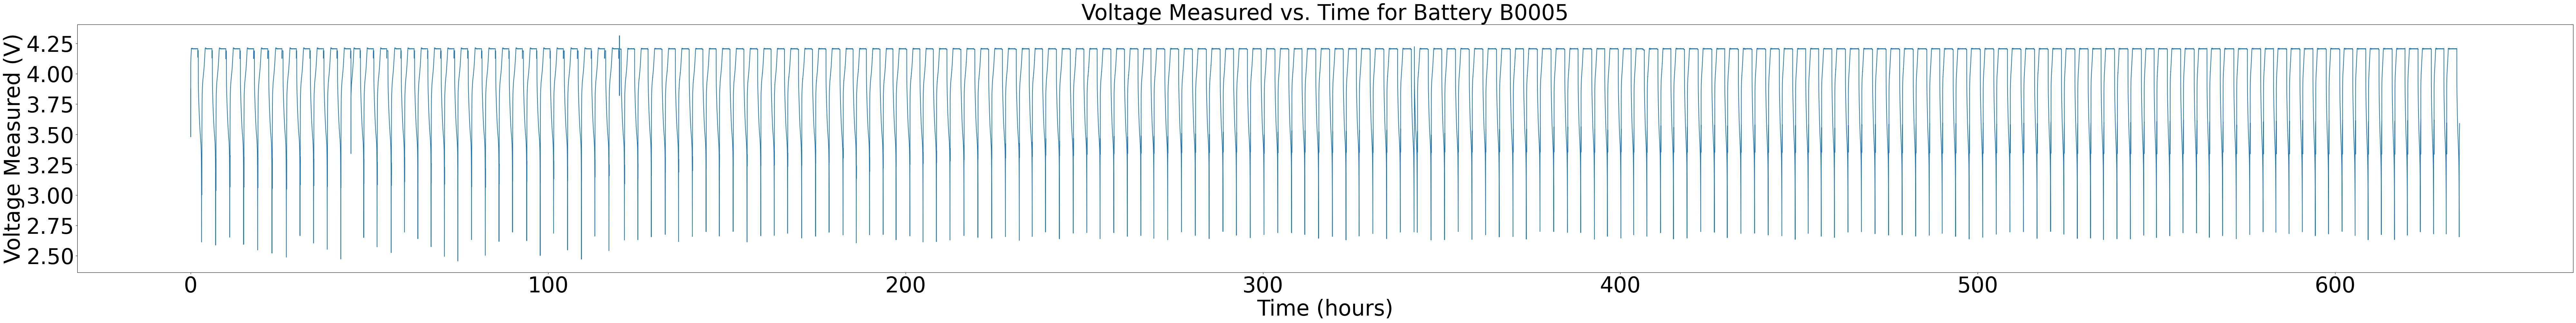

In [3]:
B5 = BatteryData("B0005")
B5.read_data()
B5.plot_full_data()

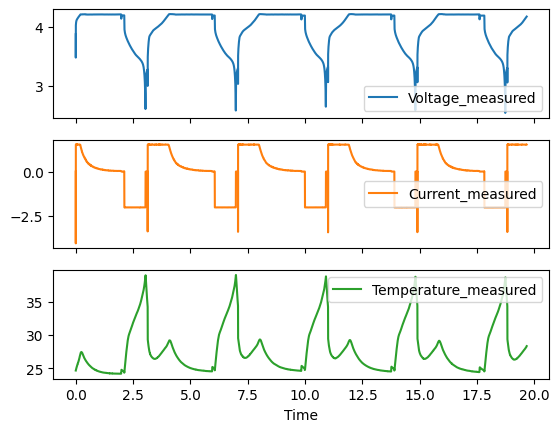

In [4]:
B5.plot_voltage_current_temperature(0, 6000)

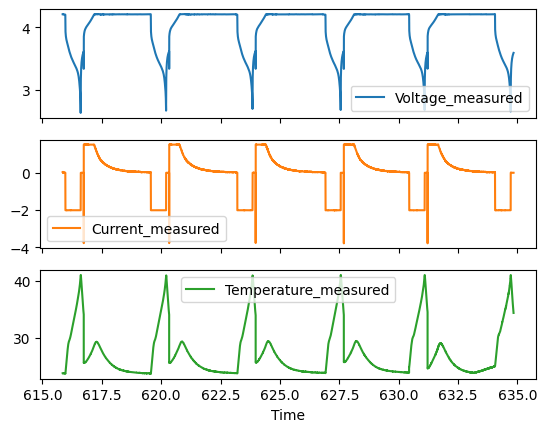

In [5]:
B5.plot_voltage_current_temperature(len(B5.df)-20000, len(B5.df))

In [6]:
train_df, val_df, test_df = B5.prepare_dataset(0.7, 0.1)

591452


In [7]:
len(train_df)

414016

In [8]:
len(test_df)

59146

In [9]:
len(val_df)

118290

### Data Windowing

In [10]:
# Taken from tutorial
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [11]:
w2 = WindowGenerator(input_width=10, label_width=1, shift=1,
                     label_columns=['Voltage_measured'])
w2

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['Voltage_measured']

In [12]:
# Taken from tutorial and modified example_window
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[i:i+w2.total_window_size]) for i in range(0, 400000, 10)])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (40000, 11, 6)
Inputs shape: (40000, 10, 6)
Labels shape: (40000, 1, 1)


In [18]:
# Taken from tutorial
w2.example = example_inputs, example_labels

def plot(self, model=None, plot_col='Voltage_measured', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=40)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=40)

    if n == 0:
      plt.legend()

  plt.xlabel('Timestep')

WindowGenerator.plot = plot

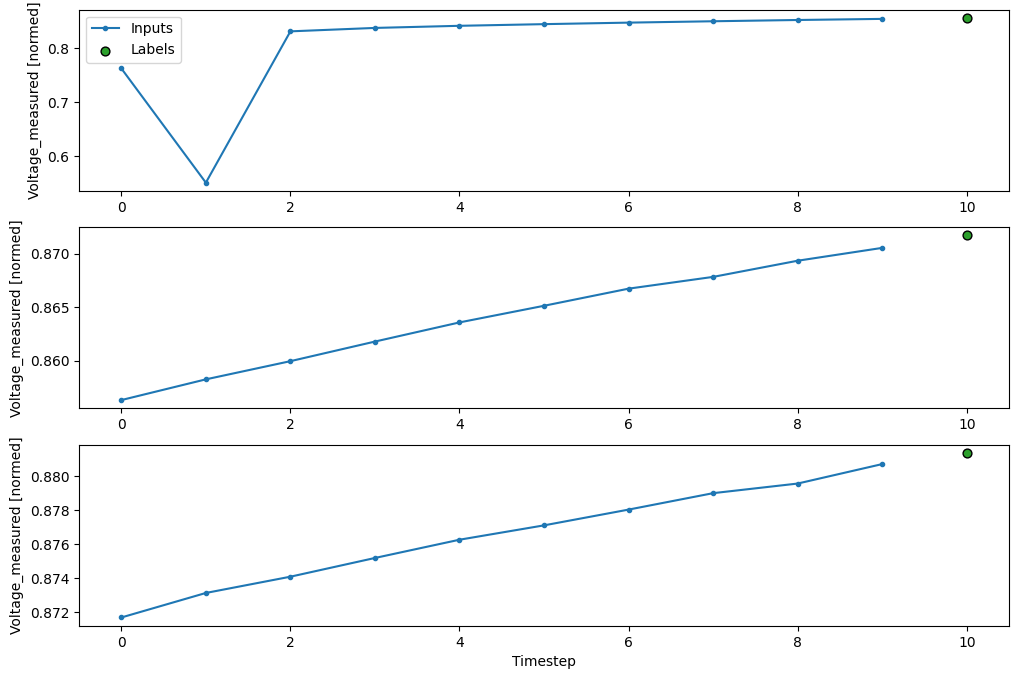

In [19]:
w2.plot()

In [20]:
# Taken from tutorial
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [21]:
# Taken from tutorial
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Fitting Setup

In [22]:
# Taken from tutorial and modified optimizer to legacy.Adam()
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [23]:
val_performance = {}
performance = {}

### CNN

In [ ]:
def cnn(conv_width, label=1):
    # Taken from tutorial
    CONV_WIDTH = conv_width
    conv_window = WindowGenerator(
        input_width=CONV_WIDTH,
        label_width=label,
        shift=1,
        label_columns=['Voltage_measured'])

    conv_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32,
                            kernel_size=(CONV_WIDTH,),
                            activation='relu'),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=1),
    ])
    # Taken from tutorial
    history = compile_and_fit(conv_model, conv_window)

    IPython.display.clear_output()
    val_performance[f'Conv_Window_{conv_width}'] = conv_model.evaluate(conv_window.val, return_dict=True)
    performance[f'Conv_Window_{conv_width}'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)
    conv_window.plot(conv_model)

    LABEL_WIDTH = 1000
    INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
    wide_conv_window = WindowGenerator(
        input_width=INPUT_WIDTH,
        label_width=LABEL_WIDTH,
        shift=1,
        label_columns=['Voltage_measured'])
    wide_conv_window.plot(conv_model)
    return conv_model

In [ ]:
# 33.4 s

 275/3697 [=>............................] - ETA: 1s - loss: 4.6150e-05 - mean_absolute_error: 0.0048

2025-05-30 22:03:37.633649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2025-05-30 22:03:37.633872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


3697/3697 [==============================] - 2s 555us/step - loss: 4.5619e-05 - mean_absolute_error: 0.0048


2025-05-30 22:03:39.728924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [59146,6]
	 [[{{node Placeholder/_0}}]]
2025-05-30 22:03:39.729130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2025-05-30 22:03:40.791548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [414016,6]
	 [[{{nod

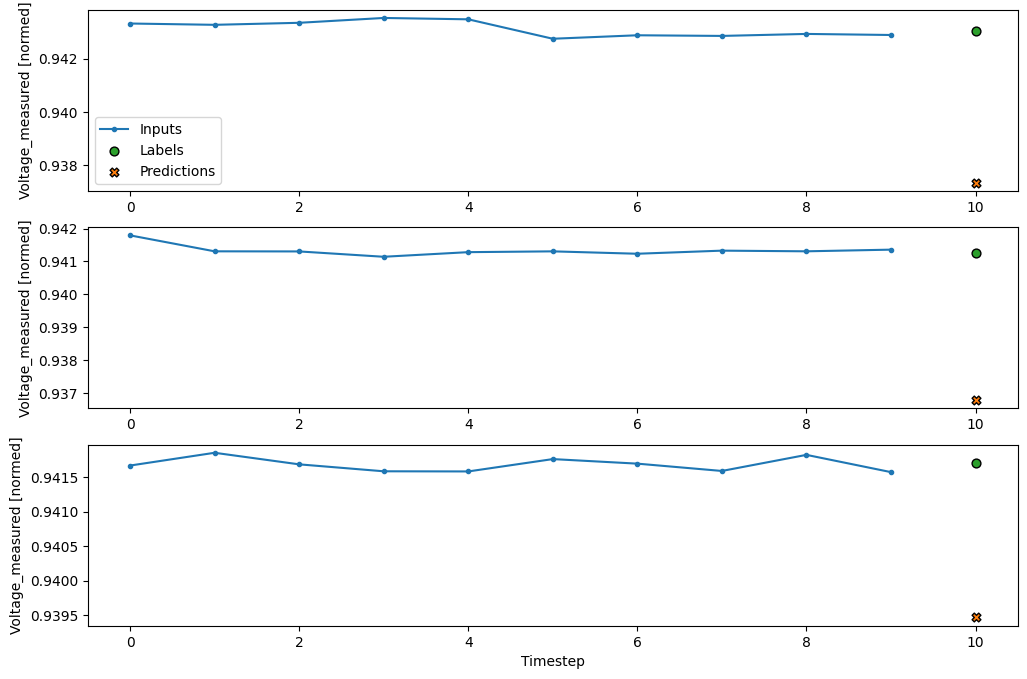

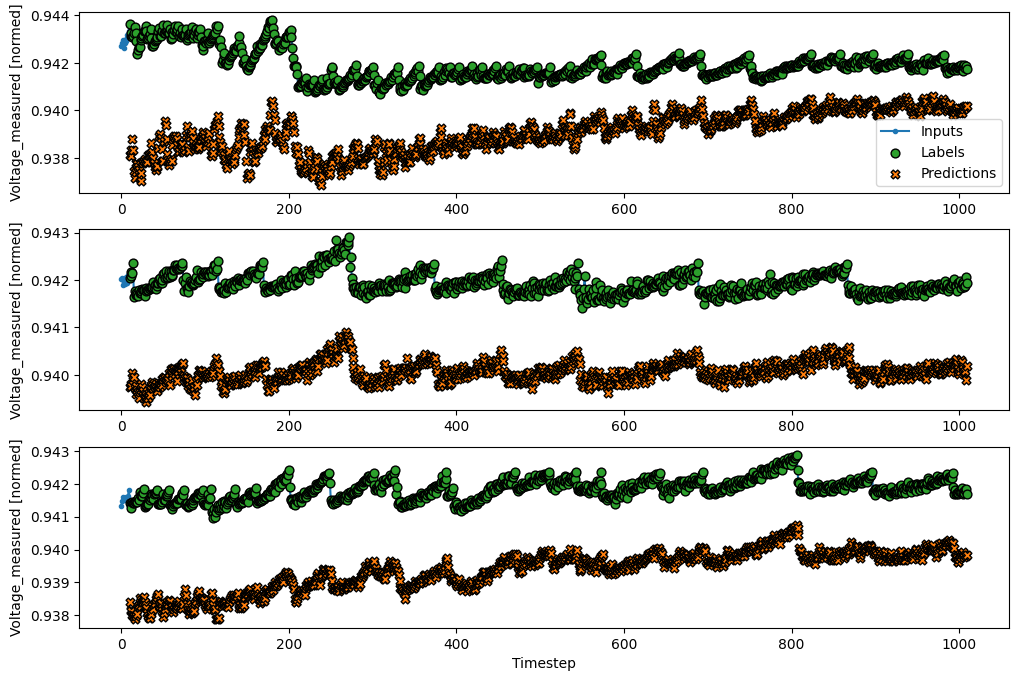

In [52]:
cnn_10 = cnn(10)

In [ ]:
# 53.1 s

 276/3697 [=>............................] - ETA: 1s - loss: 4.0730e-05 - mean_absolute_error: 0.0048

2025-05-30 22:04:30.789298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2025-05-30 22:04:30.789533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


3697/3697 [==============================] - 2s 552us/step - loss: 3.4601e-05 - mean_absolute_error: 0.0047


2025-05-30 22:04:32.868347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [59146,6]
	 [[{{node Placeholder/_0}}]]
2025-05-30 22:04:32.868554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2025-05-30 22:04:33.934119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [414011]
	 [[{{node 

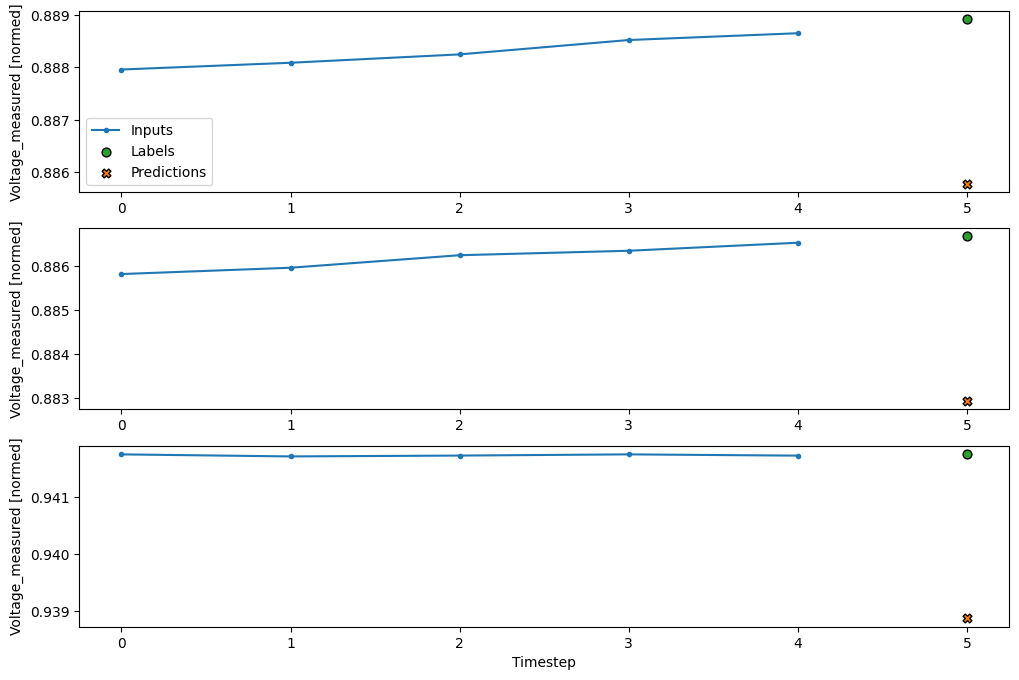

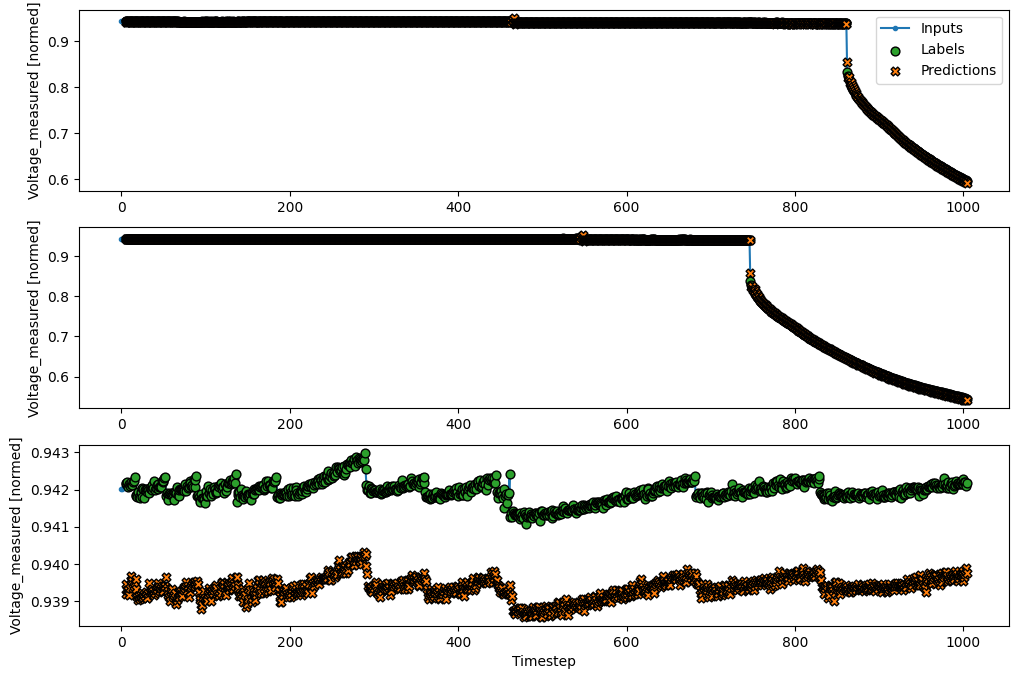

In [53]:
cnn_5 = cnn(5)

In [ ]:
# 33.7 s

 274/3695 [=>............................] - ETA: 1s - loss: 1.8336e-04 - mean_absolute_error: 0.0114

2025-05-30 22:05:04.559376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2025-05-30 22:05:04.559574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [118240]
	 [[{{node Placeholder/_8}}]]


3695/3695 [==============================] - 2s 552us/step - loss: 1.8525e-04 - mean_absolute_error: 0.0115


2025-05-30 22:05:06.634329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [59146,6]
	 [[{{node Placeholder/_0}}]]
2025-05-30 22:05:06.634536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [59146,6]
	 [[{{node Placeholder/_0}}]]
2025-05-30 22:05:07.691983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4

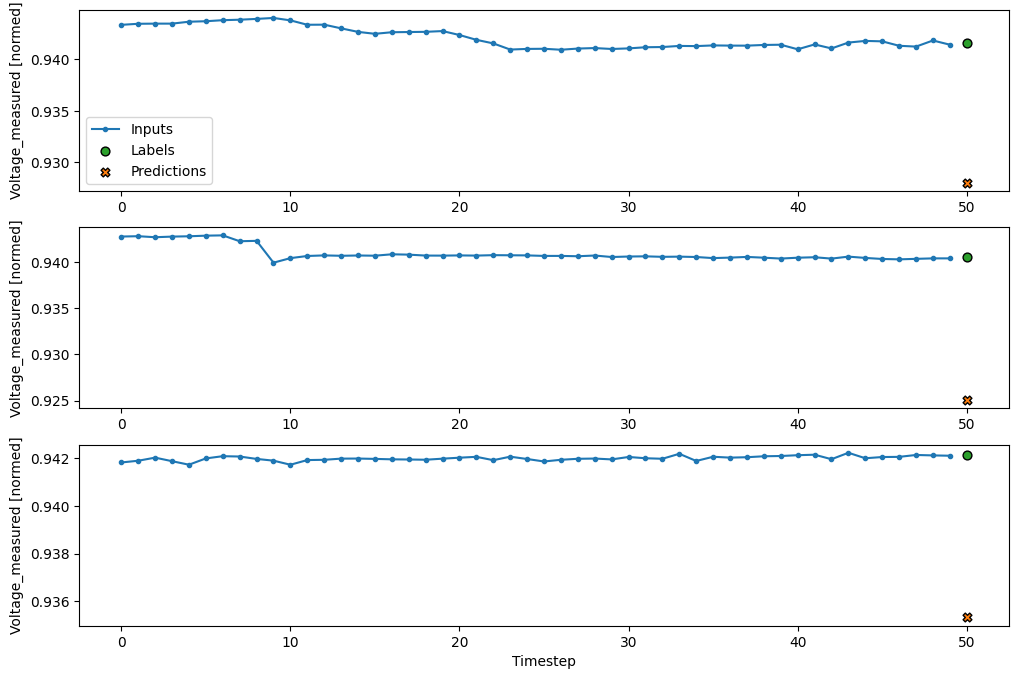

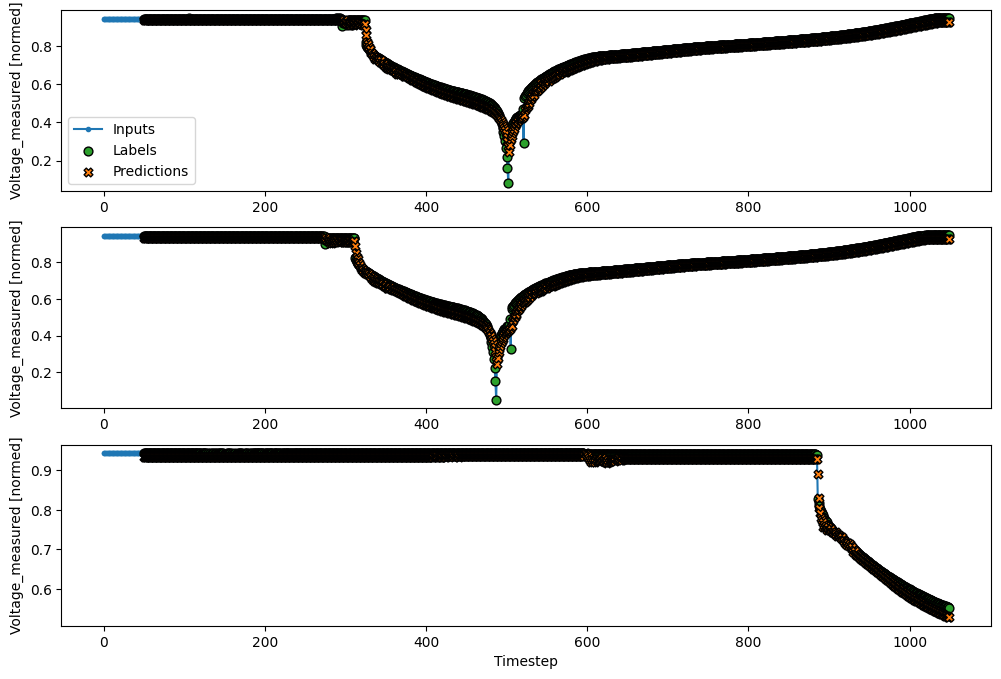

In [54]:
cnn_50 = cnn(50)

In [55]:
performance

{'Conv_Window_10': {'loss': 5.034867353970185e-05,
  'mean_absolute_error': 0.004906507208943367},
 'Conv_Window_5': {'loss': 4.093697862117551e-05,
  'mean_absolute_error': 0.005200696177780628},
 'Conv_Window_50': {'loss': 0.00016838262672536075,
  'mean_absolute_error': 0.010541606694459915}}

In [56]:
val_performance

{'Conv_Window_10': {'loss': 4.561947935144417e-05,
  'mean_absolute_error': 0.004830328747630119},
 'Conv_Window_5': {'loss': 3.460084190010093e-05,
  'mean_absolute_error': 0.004746312275528908},
 'Conv_Window_50': {'loss': 0.00018524887855164707,
  'mean_absolute_error': 0.011452043429017067}}

### LSTM

In [24]:
def lstm(input, label):
    wide_window = WindowGenerator(
    input_width=input, label_width=label, shift=1,
    label_columns=['Voltage_measured'])

    # Taken from tutorial
    lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
    ])

    # Taken from tutorial
    history = compile_and_fit(lstm_model, wide_window)

    IPython.display.clear_output()
    val_performance[f'LSTM_Window_{input}'] = lstm_model.evaluate(wide_window.val, return_dict=True)
    performance[f'LSTM_Window_{input}'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

    wide_window.plot(lstm_model)
    return lstm_model

In [ ]:
# 1m 1.8 s

 266/3697 [=>............................] - ETA: 1s - loss: 5.8999e-06 - mean_absolute_error: 6.6762e-04

2025-05-30 22:49:00.496716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2025-05-30 22:49:00.496915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [118290,6]
	 [[{{node Placeholder/_0}}]]


3697/3697 [==============================] - 2s 572us/step - loss: 6.2632e-06 - mean_absolute_error: 6.6318e-04


2025-05-30 22:49:02.649452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [59146,6]
	 [[{{node Placeholder/_0}}]]
2025-05-30 22:49:02.649647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [59141]
	 [[{{node Placeholder/_8}}]]
2025-05-30 22:49:03.751320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Pl

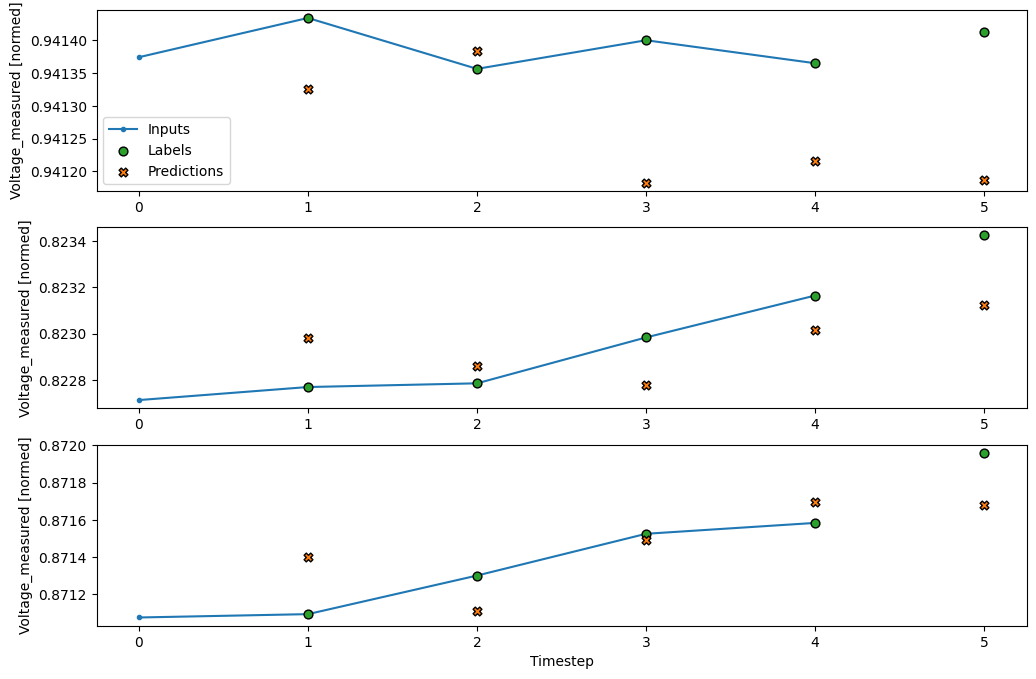

In [67]:
lstm_5 = lstm(5, 5)

In [ ]:
# 5m 17.7s

 262/3697 [=>............................] - ETA: 1s - loss: 4.2060e-06 - mean_absolute_error: 0.0010

2025-05-30 22:27:10.651032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [118280]
	 [[{{node Placeholder/_8}}]]
2025-05-30 22:27:10.651221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


3697/3697 [==============================] - 2s 571us/step - loss: 5.1969e-06 - mean_absolute_error: 0.0011


2025-05-30 22:27:12.798826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [59146,6]
	 [[{{node Placeholder/_0}}]]
2025-05-30 22:27:12.799118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2025-05-30 22:27:13.875130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [414006]
	 [[{{node 

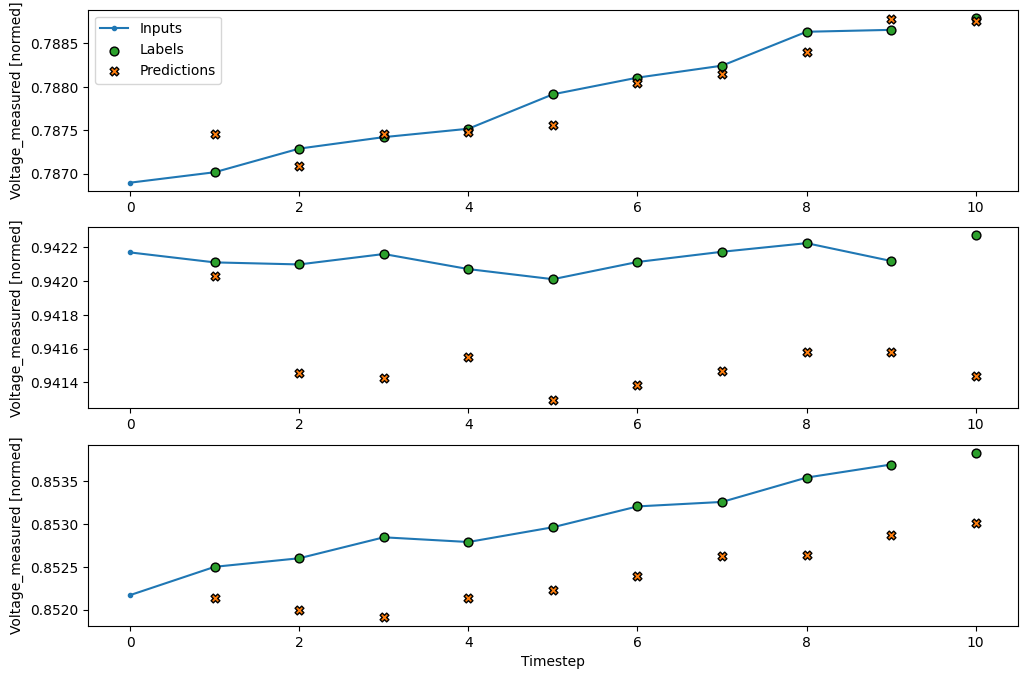

In [61]:
lstm(10, 10)

In [ ]:
# 7m 33.9 s

 117/3695 [..............................] - ETA: 4s - loss: 1.0387e-05 - mean_absolute_error: 9.9111e-04

2025-05-30 22:34:40.553783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2025-05-30 22:34:40.553982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [118240]
	 [[{{node Placeholder/_8}}]]


3695/3695 [==============================] - 5s 1ms/step - loss: 1.0331e-05 - mean_absolute_error: 0.0010


2025-05-30 22:34:45.372769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [59096]
	 [[{{node Placeholder/_8}}]]
2025-05-30 22:34:45.373009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [59146,6]
	 [[{{node Placeholder/_0}}]]
2025-05-30 22:34:47.747518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [414

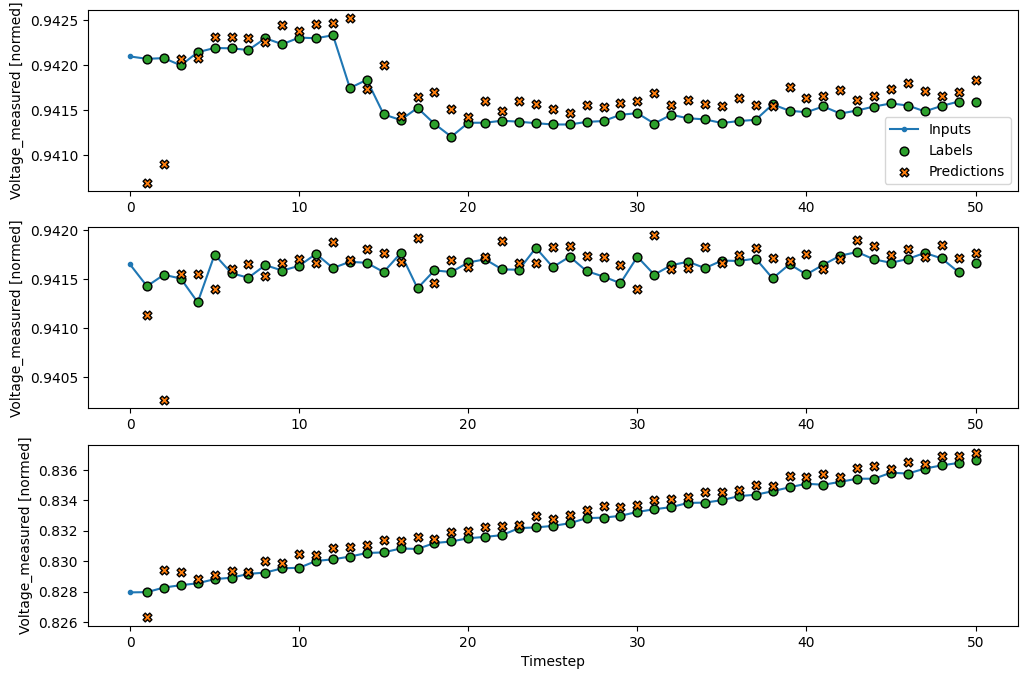

In [62]:
lstm(50, 50)

### Upfit LSTM with another Battery

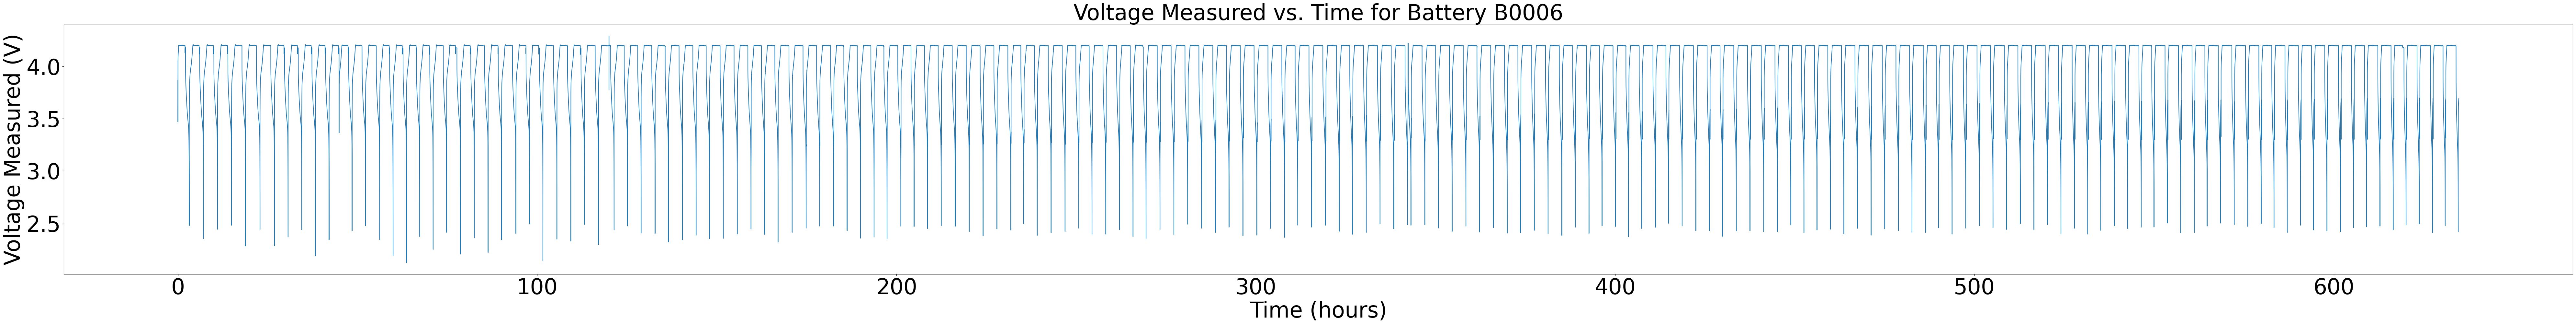

In [3]:
B6 = BatteryData("B0006")
B6.read_data()
B6.plot_full_data()

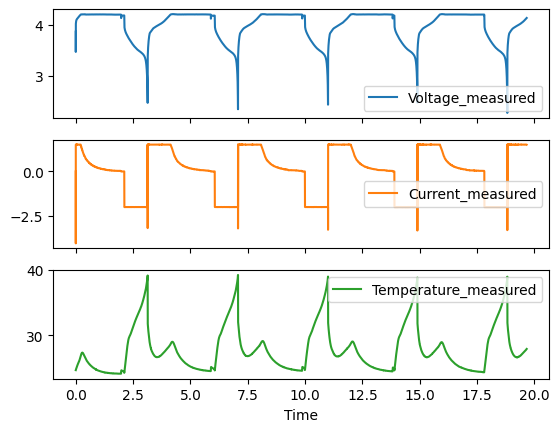

In [4]:
B6.plot_voltage_current_temperature(0, 6000)

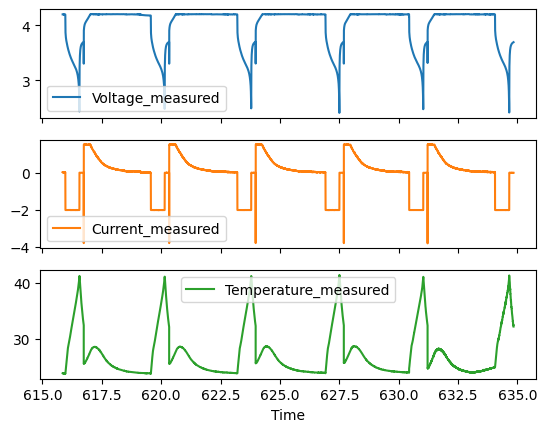

In [6]:
B6.plot_voltage_current_temperature(len(B6.df)-20000, len(B6.df))

In [64]:
train_df, val_df, test_df = B6.prepare_dataset(0.7, 0.1)

591452


In [29]:
def upfit_lstm(input, label, lstm_model):
    wide_window = WindowGenerator(
    input_width=input, label_width=label, shift=1,
    label_columns=['Voltage_measured'])

    # Taken from tutorial
    history = compile_and_fit(lstm_model, wide_window)

    IPython.display.clear_output()
    val_performance[f'Upfit_LSTM_Window_{input}'] = lstm_model.evaluate(wide_window.val, return_dict=True)
    performance[f'Upfit_LSTM_Window_{input}'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

    wide_window.plot(lstm_model)
    return lstm_model

 267/3697 [=>............................] - ETA: 1s - loss: 6.7115e-06 - mean_absolute_error: 0.0013

2025-05-30 22:51:43.332550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [118290,6]
	 [[{{node Placeholder/_0}}]]
2025-05-30 22:51:43.332740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [118290,6]
	 [[{{node Placeholder/_0}}]]


3697/3697 [==============================] - 2s 571us/step - loss: 6.3463e-06 - mean_absolute_error: 0.0013


2025-05-30 22:51:45.478579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [59146,6]
	 [[{{node Placeholder/_0}}]]
2025-05-30 22:51:45.478788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [59146,6]
	 [[{{node Placeholder/_0}}]]
2025-05-30 22:51:46.595033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4

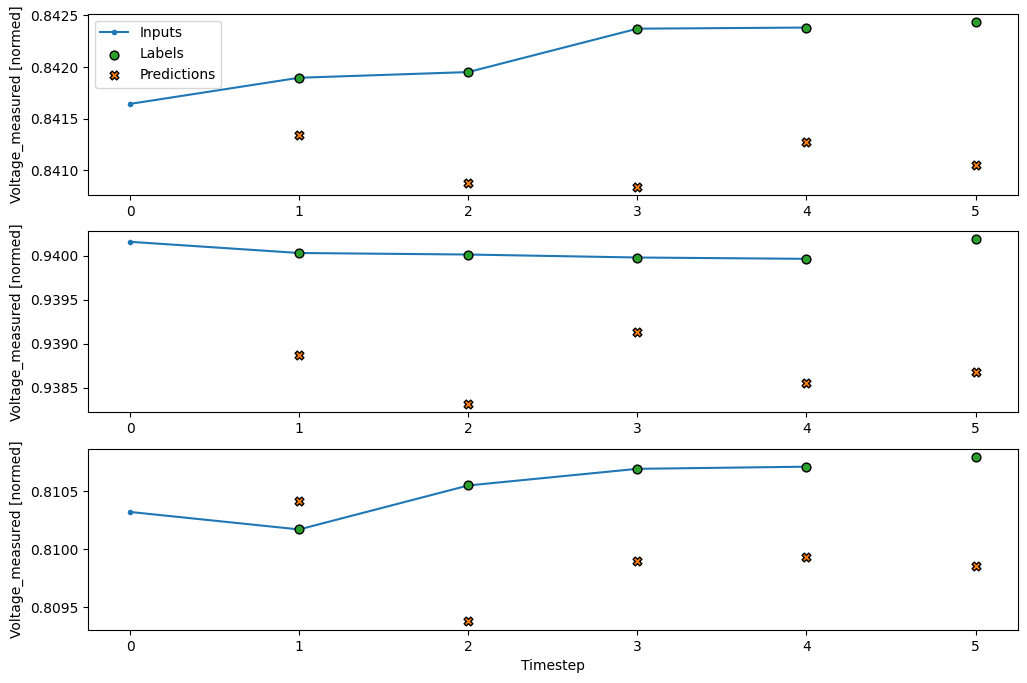

In [70]:
upfit_lstm(5, 5, lstm_5)

In [71]:
performance

{'Conv_Window_10': {'loss': 5.034867353970185e-05,
  'mean_absolute_error': 0.004906507208943367},
 'Conv_Window_5': {'loss': 4.093697862117551e-05,
  'mean_absolute_error': 0.005200696177780628},
 'Conv_Window_50': {'loss': 0.00016838262672536075,
  'mean_absolute_error': 0.010541606694459915},
 'LSTM_Window_5': {'loss': 7.888800610089675e-06,
  'mean_absolute_error': 0.000994094181805849},
 'LSTM_Window_10': {'loss': 7.392874977085739e-06,
  'mean_absolute_error': 0.0013890081318095326},
 'LSTM_Window_50': {'loss': 1.1517894563439768e-05,
  'mean_absolute_error': 0.0012313338229432702},
 'Upfit_LSTM_Window_5': {'loss': 8.652309588796925e-06,
  'mean_absolute_error': 0.0016930585261434317}}

In [72]:
val_performance

{'Conv_Window_10': {'loss': 4.561947935144417e-05,
  'mean_absolute_error': 0.004830328747630119},
 'Conv_Window_5': {'loss': 3.460084190010093e-05,
  'mean_absolute_error': 0.004746312275528908},
 'Conv_Window_50': {'loss': 0.00018524887855164707,
  'mean_absolute_error': 0.011452043429017067},
 'LSTM_Window_5': {'loss': 6.26321480012848e-06,
  'mean_absolute_error': 0.000663184910081327},
 'LSTM_Window_10': {'loss': 5.196880465518916e-06,
  'mean_absolute_error': 0.0010573494946584105},
 'LSTM_Window_50': {'loss': 1.0330664736102335e-05,
  'mean_absolute_error': 0.00100972899235785},
 'Upfit_LSTM_Window_5': {'loss': 6.346258032863261e-06,
  'mean_absolute_error': 0.0013373250840231776}}

#### Additional upfit using window width of 50

 119/3695 [..............................] - ETA: 4s - loss: 7.6793e-06 - mean_absolute_error: 0.0021

2025-06-01 16:13:13.894769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2025-06-01 16:13:13.894963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [118290,6]
	 [[{{node Placeholder/_0}}]]


3695/3695 [==============================] - 5s 1ms/step - loss: 7.0994e-06 - mean_absolute_error: 0.0021


2025-06-01 16:13:18.633887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2025-06-01 16:13:18.634092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2025-06-01 16:13:20.972563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2025-06-01 16:13

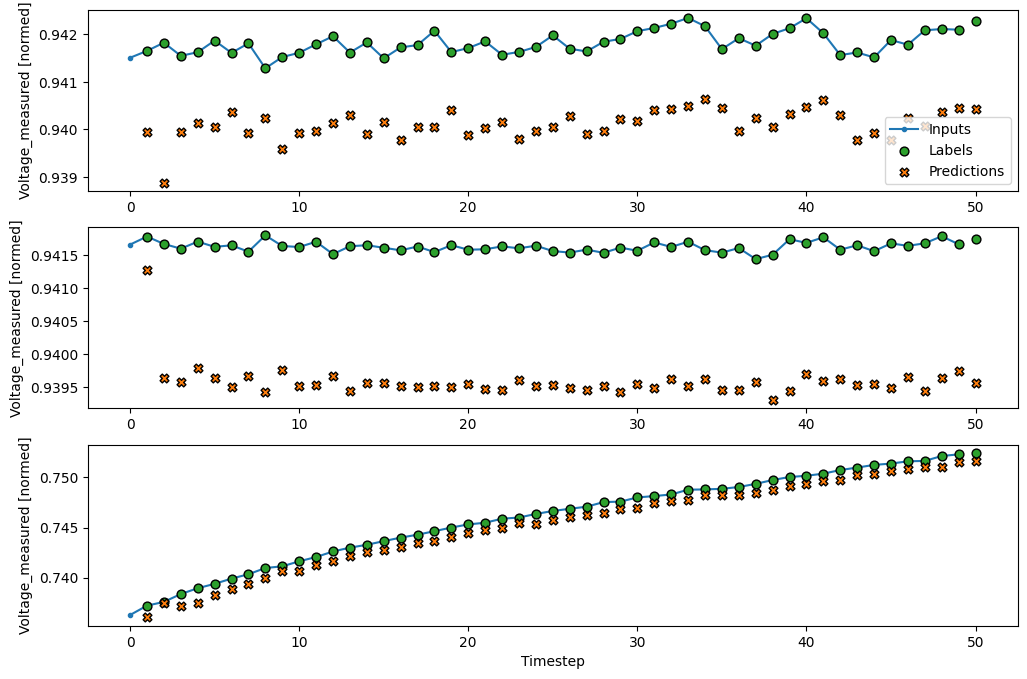

In [25]:
lstm_50 = lstm(50, 50)

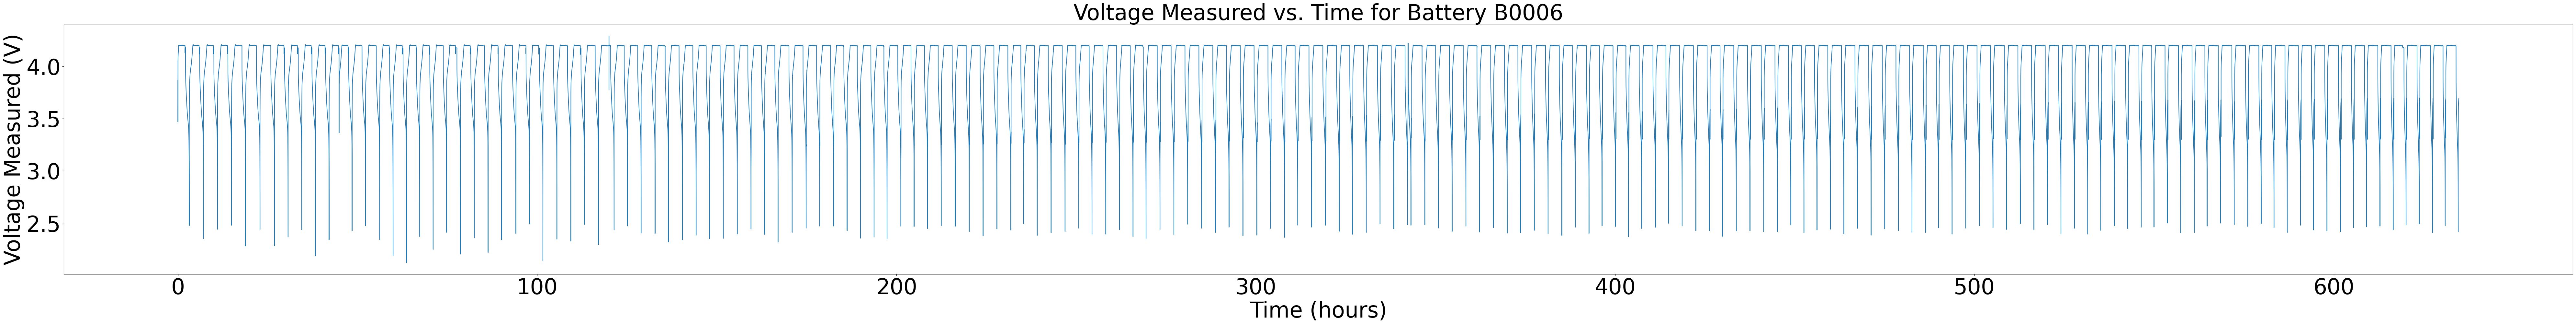

In [26]:
B6 = BatteryData("B0006")
B6.read_data()
B6.plot_full_data()

In [27]:
train_df, val_df, test_df = B6.prepare_dataset(0.7, 0.1)

591452


 117/3695 [..............................] - ETA: 4s - loss: 4.4987e-06 - mean_absolute_error: 5.3437e-04

2025-06-01 16:58:59.394352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2025-06-01 16:58:59.394566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


3695/3695 [==============================] - 5s 1ms/step - loss: 4.9391e-06 - mean_absolute_error: 5.3897e-04


2025-06-01 16:59:04.178629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [59146,6]
	 [[{{node Placeholder/_0}}]]
2025-06-01 16:59:04.178840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [59096]
	 [[{{node Placeholder/_8}}]]
2025-06-01 16:59:06.537519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Pl

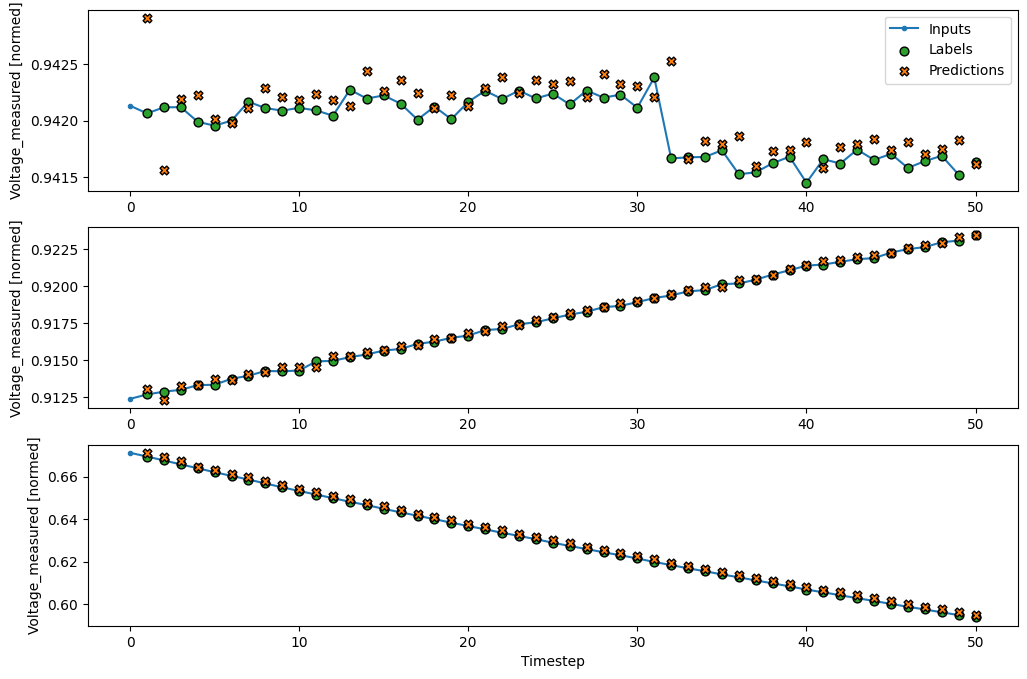

In [30]:
upfit_lstm(50, 50, lstm_50)

In [31]:
performance

{'LSTM_Window_50': {'loss': 9.840729944698978e-06,
  'mean_absolute_error': 0.0023369165137410164},
 'Upfit_LSTM_Window_50': {'loss': 7.679788723180536e-06,
  'mean_absolute_error': 0.0007497104234062135}}

In [32]:
val_performance

{'LSTM_Window_50': {'loss': 7.099446975189494e-06,
  'mean_absolute_error': 0.002072164323180914},
 'Upfit_LSTM_Window_50': {'loss': 4.9390841923013795e-06,
  'mean_absolute_error': 0.0005389709840528667}}